# TSP trên đồ thị nhỏ & so sánh GA / Greedy / 2-opt / SA

Notebook này minh hoạ bài toán **chu trình Hamilton ngắn nhất (TSP)** trên các đồ thị nhỏ:

- Demo highlight chu trình Hamilton trên **đồ thị 5 đỉnh** (cố định) để nhìn trực quan.
- Chạy **GA**, **Greedy + Local Search (2-opt)**, và **Simulated Annealing (SA)** trên **đồ thị 8 đỉnh** ngẫu nhiên (trọng số 1–20), mỗi thuật giải đều có **animation** để xem quá trình/từng bước cải thiện.

## Mục tiêu

1. Hiểu cách mỗi thuật giải tìm tour và cải thiện chất lượng.
2. So sánh **tốc độ / chất lượng / rủi ro kẹt cục bộ / tham số**.
3. Liên hệ **tối ưu layout cửa hàng**: làm sao ánh xạ bài toán thực tế sang bài toán TSP/FLP và chọn thuật giải phù hợp.


## Demo 5 đỉnh: highlight một chu trình Hamilton bất kỳ

- Đồ thị 5 đỉnh với trọng số cố định.
- Animation sẽ **tô đỏ lần lượt** các cạnh trên chu trình `1 → 2 → 5 → 4 → 3 → 1` để minh hoạ khái niệm.


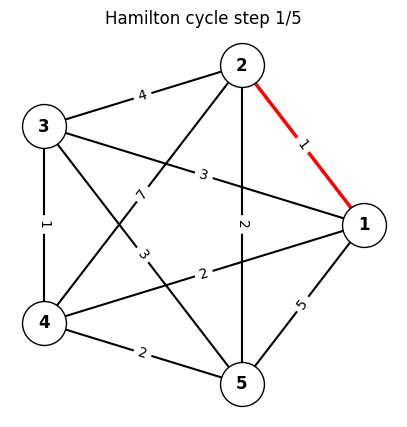

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# -------------------------
# 1. Dữ liệu đồ thị
# -------------------------
edges = [
    (1, 2, 1),
    (1, 3, 3),
    (1, 4, 2),
    (1, 5, 5),
    (2, 3, 4),
    (2, 4, 7),
    (2, 5, 2),
    (3, 4, 1),
    (3, 5, 3),
    (4, 5, 2),
]

G = nx.Graph()
for u, v, w in edges:
    G.add_edge(u, v, weight=w)

# Layout vòng tròn
pos = nx.circular_layout(G)

# -------------------------
# 2. Chu trình Hamilton cần highlight
# -------------------------
hamilton_cycle = [1, 2, 5, 4, 3, 1]  # ví dụ
cycle_edges = [
    (hamilton_cycle[i], hamilton_cycle[i + 1]) for i in range(len(hamilton_cycle) - 1)
]

# -------------------------
# 3. Hàm vẽ mỗi frame
# -------------------------
fig, ax = plt.subplots(figsize=(5, 5))


def update(frame):
    ax.clear()
    # Vẽ node
    nx.draw_networkx_nodes(
        G, pos, node_color="white", edgecolors="black", node_size=1000, ax=ax
    )
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold", ax=ax)
    # Vẽ tất cả cạnh màu đen
    nx.draw_networkx_edges(
        G, pos, edgelist=G.edges, width=1.5, edge_color="black", ax=ax
    )
    # Highlight các cạnh trong đường đi từ đầu đến frame hiện tại
    nx.draw_networkx_edges(
        G, pos, edgelist=cycle_edges[: frame + 1], width=2.5, edge_color="red", ax=ax
    )
    # Vẽ nhãn trọng số
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, ax=ax)
    ax.set_title(f"Hamilton cycle step {frame+1}/{len(cycle_edges)}")
    ax.axis("off")


# -------------------------
# 4. Tạo animation & hiển thị
# -------------------------
ani = FuncAnimation(fig, update, frames=len(cycle_edges), interval=800, repeat=False)
HTML(ani.to_jshtml())

## GA (Genetic Algorithm) trên đồ thị 8 đỉnh ngẫu nhiên

**Ý tưởng:** biểu diễn tour là nhiễm sắc thể, dùng **crossover OX** và **đột biến đảo đoạn (inversion)**, chọn lọc theo **tournament** + **elitism**.  
**Mục tiêu:** tối thiểu độ dài tour, lưu **best tour mỗi thế hệ** để animation thấy tiến bộ.

**Tham số mặc định** (có thể đổi):

- `pop_size=60`, `generations=50`
- `p_cx=0.9`, `p_mut=0.3`, `elite_size=2`, `tourn_k=3`

**Gợi ý:** Nếu best hội tụ quá nhanh, hãy tăng `p_mut`, giảm `elite_size`, hoặc tăng `generations` để thấy quá trình cải thiện rõ hơn.


Best GA tour: [4, 5, 3, 1, 6, 8, 7, 2]
Best GA length: 32.0


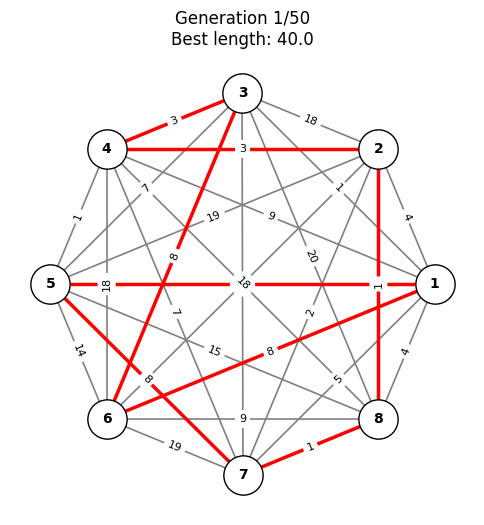

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# -------------------------
# 1. Tạo đồ thị 8 đỉnh với trọng số ngẫu nhiên
# -------------------------
n_nodes = 8
nodes = list(range(1, n_nodes + 1))

edges = []
random.seed(42)
for i in range(1, n_nodes + 1):
    for j in range(i + 1, n_nodes + 1):
        w = random.randint(1, 20)  # trọng số ngẫu nhiên 1–20
        edges.append((i, j, w))

G = nx.Graph()
for u, v, w in edges:
    G.add_edge(u, v, weight=w)

# Ma trận trọng số
weight_matrix = np.full((n_nodes, n_nodes), np.inf)
for u, v, w in edges:
    weight_matrix[u - 1, v - 1] = w
    weight_matrix[v - 1, u - 1] = w


# -------------------------
# 2. GA cho TSP trên đồ thị này
# -------------------------
def tour_length(tour):
    length = 0
    for i in range(len(tour) - 1):
        length += weight_matrix[tour[i] - 1, tour[i + 1] - 1]
    length += weight_matrix[tour[-1] - 1, tour[0] - 1]
    return length


def fitness(length):
    return 1.0 / (length + 1e-9)


def initial_population(pop_size):
    pop = []
    base = nodes.copy()
    for _ in range(pop_size):
        indiv = base.copy()
        random.shuffle(indiv)
        pop.append(indiv)
    return pop


def tournament_selection(pop, fits, k=3):
    selected_idx = random.sample(range(len(pop)), k)
    best = max(selected_idx, key=lambda idx: fits[idx])
    return pop[best][:]


def ox_crossover(p1, p2):
    n = len(p1)
    c1, c2 = sorted(random.sample(range(n), 2))
    child = [None] * n
    child[c1 : c2 + 1] = p1[c1 : c2 + 1]
    p2_items = [gene for gene in p2 if gene not in child]
    pos = 0
    for i in range(n):
        if child[i] is None:
            child[i] = p2_items[pos]
            pos += 1
    return child


def inversion_mutation(indiv, p_mut=0.3):
    if random.random() < p_mut:
        i, j = sorted(random.sample(range(len(indiv)), 2))
        indiv[i : j + 1] = reversed(indiv[i : j + 1])


def evolve(pop, elite_size=2, p_cx=0.9, p_mut=0.3, tourn_k=3):
    lengths = np.array([tour_length(ind) for ind in pop], dtype=float)
    fits = np.array([fitness(L) for L in lengths], dtype=float)
    idx_sorted = np.argsort(-fits)
    pop = [pop[i] for i in idx_sorted]
    fits = fits[idx_sorted]
    new_pop = []
    for i in range(elite_size):
        new_pop.append(pop[i][:])
    while len(new_pop) < len(pop):
        p1 = tournament_selection(pop, fits, k=tourn_k)
        p2 = tournament_selection(pop, fits, k=tourn_k)
        if random.random() < p_cx:
            child = ox_crossover(p1, p2)
        else:
            child = p1[:]
        inversion_mutation(child, p_mut)
        new_pop.append(child)
    return new_pop


# -------------------------
# 3. Chạy GA và lưu best tour mỗi thế hệ
# -------------------------
pop_size = 60
generations = 50
population = initial_population(pop_size)

best_per_gen = []
best_len_per_gen = []

for gen in range(generations):
    lengths = [tour_length(ind) for ind in population]
    min_len = min(lengths)
    best_tour = population[lengths.index(min_len)][:]
    best_per_gen.append(best_tour)
    best_len_per_gen.append(min_len)
    population = evolve(population, elite_size=2, p_cx=0.9, p_mut=0.3, tourn_k=3)

# -------------------------
# 4. Animation hiển thị cải thiện qua từng thế hệ
# -------------------------
pos = nx.circular_layout(G)  # bố cục vòng tròn
fig, ax = plt.subplots(figsize=(6, 6))


def update(frame):
    ax.clear()
    tour = best_per_gen[frame]
    length = best_len_per_gen[frame]
    cycle_edges = [(tour[i], tour[i + 1]) for i in range(len(tour) - 1)] + [
        (tour[-1], tour[0])
    ]
    nx.draw_networkx_nodes(
        G, pos, node_color="white", edgecolors="black", node_size=800, ax=ax
    )
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold", ax=ax)
    nx.draw_networkx_edges(
        G, pos, edgelist=G.edges, width=1.2, edge_color="gray", ax=ax
    )
    nx.draw_networkx_edges(
        G, pos, edgelist=cycle_edges, width=2.5, edge_color="red", ax=ax
    )
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels=nx.get_edge_attributes(G, "weight"), font_size=8, ax=ax
    )
    ax.set_title(f"Generation {frame+1}/{generations}\nBest length: {length}")
    ax.axis("off")


print("Best GA tour:", best_per_gen[-1])
print("Best GA length:", best_len_per_gen[-1])

ani = FuncAnimation(fig, update, frames=generations, interval=600, repeat=False)
HTML(ani.to_jshtml())

## Greedy + Local Search (2-opt)

**Greedy:** bắt đầu từ 1 (mặc định), luôn chọn **đỉnh chưa thăm gần nhất** → có tour nhanh nhưng dễ **kẹt cục bộ**.  
**2-opt:** hoán đổi 2 cạnh (đảo đoạn) để giảm độ dài. Lặp đến khi không cải thiện → **local optimum**.

**Ưu:** đơn giản, nhanh, dễ triển khai.  
**Nhược:** chất lượng phụ thuộc điểm bắt đầu và dễ kẹt cục bộ (không chấp nhận bước xấu tạm thời).


Greedy length: 37.0 Tour: [1, 3, 4, 5, 7, 8, 2, 6]
Local Search length: 34.0 Tour: [1, 2, 8, 7, 5, 4, 3, 6]


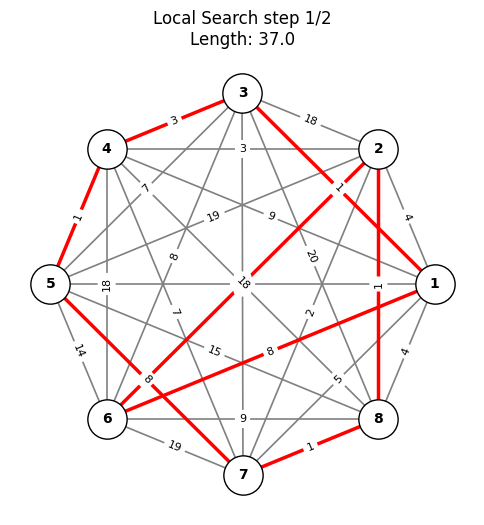

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# -------------------------
# 1. Đồ thị 8 đỉnh giống bản GA
# -------------------------
n_nodes = 8
nodes = list(range(1, n_nodes + 1))
edges = []
random.seed(42)
for i in range(1, n_nodes + 1):
    for j in range(i + 1, n_nodes + 1):
        w = random.randint(1, 20)
        edges.append((i, j, w))

G = nx.Graph()
for u, v, w in edges:
    G.add_edge(u, v, weight=w)

# Ma trận trọng số
weight_matrix = np.full((n_nodes, n_nodes), np.inf)
for u, v, w in edges:
    weight_matrix[u - 1, v - 1] = w
    weight_matrix[v - 1, u - 1] = w


def tour_length(tour):
    length = 0
    for i in range(len(tour) - 1):
        length += weight_matrix[tour[i] - 1, tour[i + 1] - 1]
    length += weight_matrix[tour[-1] - 1, tour[0] - 1]
    return length


# -------------------------
# 2. Greedy tour từ node start
# -------------------------
def greedy_tour(start=1):
    unvisited = set(nodes)
    tour = [start]
    unvisited.remove(start)
    while unvisited:
        last = tour[-1]
        next_city = min(unvisited, key=lambda city: weight_matrix[last - 1, city - 1])
        tour.append(next_city)
        unvisited.remove(next_city)
    return tour


# -------------------------
# 3. Local Search (2-opt)
# -------------------------
def two_opt(tour):
    best = tour
    improved = True
    tours_sequence = [best[:]]
    while improved:
        improved = False
        for i in range(1, len(tour) - 2):
            for j in range(i + 1, len(tour)):
                if j - i == 1:
                    continue
                new_tour = best[:]
                new_tour[i:j] = reversed(best[i:j])
                if tour_length(new_tour) < tour_length(best):
                    best = new_tour
                    tours_sequence.append(best[:])
                    improved = True
        tour = best
    return best, tours_sequence


# -------------------------
# 4. Chạy Greedy + Local Search
# -------------------------
greedy_start = 1
greedy_result = greedy_tour(start=greedy_start)
best_local, sequence_local = two_opt(greedy_result)

print("Greedy length:", tour_length(greedy_result), "Tour:", greedy_result)
print("Local Search length:", tour_length(best_local), "Tour:", best_local)

# -------------------------
# 5. Animation quá trình Local Search
# -------------------------
pos = nx.circular_layout(G)
fig, ax = plt.subplots(figsize=(6, 6))


def update(frame):
    ax.clear()
    tour = sequence_local[frame]
    length = tour_length(tour)
    cycle_edges = [(tour[i], tour[i + 1]) for i in range(len(tour) - 1)] + [
        (tour[-1], tour[0])
    ]
    nx.draw_networkx_nodes(
        G, pos, node_color="white", edgecolors="black", node_size=800, ax=ax
    )
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold", ax=ax)
    nx.draw_networkx_edges(
        G, pos, edgelist=G.edges, width=1.2, edge_color="gray", ax=ax
    )
    nx.draw_networkx_edges(
        G, pos, edgelist=cycle_edges, width=2.5, edge_color="red", ax=ax
    )
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels=nx.get_edge_attributes(G, "weight"), font_size=8, ax=ax
    )
    ax.set_title(f"Local Search step {frame+1}/{len(sequence_local)}\nLength: {length}")
    ax.axis("off")


ani = FuncAnimation(fig, update, frames=len(sequence_local), interval=800, repeat=False)
HTML(ani.to_jshtml())

## Simulated Annealing (SA)

**Ý tưởng:** bắt chước luyện kim: lúc đầu **chấp nhận** cả bước xấu với xác suất \( e^{-\Delta L/T} \) để **tránh kẹt cục bộ**, sau đó **giảm nhiệt** dần (\(T \downarrow\)).  
**Láng giềng:** đảo đoạn (2-opt move).  
**Lưu `history_sa`:** mỗi khi tìm được **best** mới, ta lưu lại để animation chỉ hiển thị những **bước cải thiện thực sự**.

**Tham số gợi ý:**

- `T_start=100` (nhiệt đầu), `alpha=0.995` (tốc độ làm nguội), `T_end=1e-3`, `max_iter=5000`.
- Nếu cải thiện nhanh quá chậm: tăng `T_start` hoặc giảm `alpha` (làm nguội chậm hơn).


Initial tour: [2, 5, 6, 7, 4, 8, 3, 1] Length: 102.0
Best SA tour: [3, 5, 4, 2, 7, 8, 6, 1] Length: 32.0


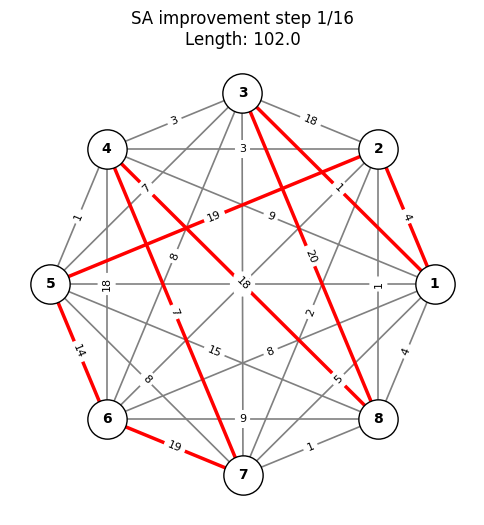

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import math

# -------------------------
# 1. Đồ thị 8 đỉnh (giống trước)
# -------------------------
n_nodes = 8
nodes = list(range(1, n_nodes + 1))
edges = []
random.seed(42)
for i in range(1, n_nodes + 1):
    for j in range(i + 1, n_nodes + 1):
        w = random.randint(1, 20)
        edges.append((i, j, w))

G = nx.Graph()
for u, v, w in edges:
    G.add_edge(u, v, weight=w)

# Ma trận trọng số
weight_matrix = np.full((n_nodes, n_nodes), np.inf)
for u, v, w in edges:
    weight_matrix[u - 1, v - 1] = w
    weight_matrix[v - 1, u - 1] = w


def tour_length(tour):
    length = 0
    for i in range(len(tour) - 1):
        length += weight_matrix[tour[i] - 1, tour[i + 1] - 1]
    length += weight_matrix[tour[-1] - 1, tour[0] - 1]
    return length


# -------------------------
# 2. Simulated Annealing
# -------------------------
def simulated_annealing(
    initial_tour, T_start=100, T_end=1e-3, alpha=0.995, max_iter=5000
):
    current_tour = initial_tour[:]
    current_len = tour_length(current_tour)
    best_tour = current_tour[:]
    best_len = current_len

    T = T_start
    history = [(best_tour[:], best_len)]

    for step in range(max_iter):
        # Tạo neighbor bằng đảo ngược đoạn (2-opt)
        i, j = sorted(random.sample(range(len(current_tour)), 2))
        neighbor = current_tour[:]
        neighbor[i : j + 1] = reversed(neighbor[i : j + 1])
        neighbor_len = tour_length(neighbor)

        delta = neighbor_len - current_len
        if delta < 0 or random.random() < math.exp(-delta / T):
            current_tour = neighbor
            current_len = neighbor_len
            if current_len < best_len:
                best_tour = current_tour[:]
                best_len = current_len
                history.append((best_tour[:], best_len))

        T *= alpha
        if T < T_end:
            break

    return best_tour, best_len, history


# -------------------------
# 3. Chạy SA
# -------------------------
random.seed(123)
initial_tour = nodes[:]
random.shuffle(initial_tour)

best_sa, best_len_sa, history_sa = simulated_annealing(initial_tour)

print("Initial tour:", initial_tour, "Length:", tour_length(initial_tour))
print("Best SA tour:", best_sa, "Length:", best_len_sa)

# -------------------------
# 4. Animation quá trình SA cải thiện
# -------------------------
pos = nx.circular_layout(G)
fig, ax = plt.subplots(figsize=(6, 6))


def update(frame):
    ax.clear()
    tour, length = history_sa[frame]
    cycle_edges = [(tour[i], tour[i + 1]) for i in range(len(tour) - 1)] + [
        (tour[-1], tour[0])
    ]
    nx.draw_networkx_nodes(
        G, pos, node_color="white", edgecolors="black", node_size=800, ax=ax
    )
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold", ax=ax)
    nx.draw_networkx_edges(
        G, pos, edgelist=G.edges, width=1.2, edge_color="gray", ax=ax
    )
    nx.draw_networkx_edges(
        G, pos, edgelist=cycle_edges, width=2.5, edge_color="red", ax=ax
    )
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels=nx.get_edge_attributes(G, "weight"), font_size=8, ax=ax
    )
    ax.set_title(f"SA improvement step {frame+1}/{len(history_sa)}\nLength: {length}")
    ax.axis("off")


ani = FuncAnimation(fig, update, frames=len(history_sa), interval=800, repeat=False)
HTML(ani.to_jshtml())

## So sánh nhanh các thuật giải

| Tiêu chí                   | Greedy         | Local Search (2-opt)            | SA                                   | GA                                      |
| -------------------------- | -------------- | ------------------------------- | ------------------------------------ | --------------------------------------- |
| **Chất lượng nghiệm**      | Trung bình     | Khá (local optimum)             | Tốt (tránh kẹt cục bộ)               | Tốt/ rất tốt (đa dạng quần thể)         |
| **Tốc độ**                 | Rất nhanh      | Nhanh                           | Vừa                                  | Vừa–chậm (tùy tham số)                  |
| **Kẹt cục bộ**             | Cao            | Cao (nếu không random-restarts) | Thấp hơn nhờ nhiệt                   | Thấp hơn nhờ crossover+mutation         |
| **Tham số cần tinh chỉnh** | Ít             | Ít                              | Vừa (T_start, alpha, lịch làm nguội) | Nhiều (pop, gens, p_cx, p_mut, elitism) |
| **Quy mô phù hợp**         | Nhỏ–trung bình | Nhỏ–trung bình                  | Trung bình                           | Trung bình–lớn                          |

**Khi nào dùng cái nào?**

- **Greedy**: baseline rất nhanh để khởi đầu.
- **2-opt**: cải thiện nhanh từ lời giải Greedy.
- **SA**: muốn vượt local optimum nhưng vẫn đơn giản.
- **GA**: có thời gian/nhu cầu chất lượng cao, ràng buộc phức tạp (có thể encode).


## Tối ưu layout cửa hàng (retail)

**Bài toán thực tế**: sắp xếp vị trí kệ/sản phẩm để **tối đa doanh thu** hoặc **giảm quãng đường di chuyển**, tăng **bán kèm**.

**Cách ánh xạ sang tối ưu tổ hợp**:

- **Trọng số cạnh** có thể đến từ **Association Rules**: dùng **lift/conviction** giữa cặp sản phẩm để tạo "độ hấp dẫn đặt gần nhau" (trọng số nhỏ = muốn gần/ưu tiên).
- Hoặc dùng **tần suất mua chung (support)** hoặc **xác suất chuyển đổi** giữa khu vực để tạo **ma trận chi phí/quãng đường kỳ vọng**.
- Ràng buộc: sức chứa kệ, khoảng cách lối đi, khu cấm, vị trí điện/nước, nhóm sản phẩm phải cách xa/đi kèm, v.v.

**Chọn thuật giải**:

- **Greedy/2-opt**: khi cần kế hoạch sơ bộ nhanh, hoặc update layout thường xuyên (AB test)
- **SA**: phù hợp khi có nhiều ràng buộc mềm/cứng, muốn thoát local optimum nhưng setup đơn giản
- **GA**: khi mô hình phức tạp, nhiều ràng buộc, đa mục tiêu (doanh thu, lộ trình, tồn kho…). Có thể mã hoá **nhiều tiêu chí** vào fitness, ví dụ:  
  `fitness = w1*(−doanh_thu_ước_tính) + w2*(quãng_đường_khách) + w3*(phạt_vi_phạm_ràng_buộc)`

**Quy trình**:

1. Dùng **Association Rules** để lấy các cặp/cụm sản phẩm mua chung (lift cao).
2. **Gom cụm** sản phẩm liên quan → nhóm đặt gần nhau (giảm kích thước bài toán).
3. Tạo **ma trận chi phí/độ hấp dẫn** (từ lift/flow khách/biên lợi nhuận).
4. Chạy **SA/GA** để tối ưu vị trí + ràng buộc (khoảng cách, luồng đi lại,…).
5. **Local Search** hậu kỳ để tinh chỉnh nhanh (2-opt/3-opt trên thứ tự kệ).
